In [1]:
# Combine all cities into a single featurespace 

import os
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.base import BaseEstimator, TransformerMixin
from source.DataFrameSelector import DataFrameSelector, PrefixDataFrameSelector, PrefixMeanDataFrameSelector

DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

def mean_absolute_percentage_error(actual, forecast):
    return np.mean(np.abs(np.divide(np.subtract(actual, forecast), actual))) * 100

In [2]:
def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)
    return df

def get_price():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price", "price day ahead"]].rename(columns={"price day ahead": "TSO_price_forecast"})
    
def add_price_x_hours_before(df, hours):
    return df.join(df["price"].shift(periods=hours), lsuffix="", rsuffix="_%dh_before" % hours).dropna()

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)

def calendar_week_max(year):
    # https://docs.python.org/3/library/datetime.html
    # see datetime.isocalendar() on why we take 28 instead of 31
    return datetime(year, 12, 28).isocalendar()[1]

def encode_cyclic(value, max_value):
    assert value >= 0
    # min_value must be 0
    sin_coord = np.sin(2*np.pi*value/max_value)
    cos_coord = np.cos(2*np.pi*value/max_value)
    return sin_coord, cos_coord

def encode_date(utc_date: datetime):
    encoded_cw = encode_cyclic(utc_date.isocalendar()[1] - 1, calendar_week_max(utc_date.year) - 1)
    encoded_iso_weekday = encode_cyclic(utc_date.isoweekday() - 1, 7 - 1) # isoweekday goes from 1 (Monday) to 7 (Sunday)
    encoded_hour = encode_cyclic(utc_date.hour, 24)
    return (utc_date.isocalendar()[0], *encoded_cw, *encoded_iso_weekday,*encoded_hour)

In [3]:
def add_weather_data_by_group(price):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    groups = w_data.groupby("city_name")
    for label in groups.groups:
        df = groups.get_group(label)
        df = df.drop(columns="city_name").add_suffix("_%s" % label).rename(columns={"time_%s" % label: "time"})
        price = price.merge(right=df, how="inner", on="time", suffixes=(False, False))
    return price

data = to_utc_datetime(add_weather_data_by_group(get_price()))
encoded_dates = data.apply(lambda row: encode_date(row["time"]), axis=1)
data["iso_year"], data["sin_cw"], data["cos_cw"], data["sin_wd"], data["cos_wd"], data["sin_h"], data["cos_h"] = zip(*encoded_dates)

In [8]:
data.tail()

,time,price,TSO_price_forecast,temp_ Barcelona,pressure_ Barcelona,humidity_ Barcelona,wind_speed_ Barcelona,wind_deg_ Barcelona,rain_1h_ Barcelona,rain_3h_ Barcelona,...,clouds_all_Valencia,weather_main_Valencia,weather_description_Valencia,iso_year,sin_cw,cos_cw,sin_wd,cos_wd,sin_h,cos_h
38563,2018-12-31 18:00:00+00:00,77.02,68.85,284.13,1027,71,1,250,0.0,0.0,...,0,clear,sky is clear,2019,0.0,1.0,0.0,1.0,-1.000000,-1.836970e-16
38564,2018-12-31 19:00:00+00:00,76.16,68.40,282.64,1027,62,3,270,0.0,0.0,...,0,clear,sky is clear,2019,0.0,1.0,0.0,1.0,-0.965926,2.588190e-01
38565,2018-12-31 20:00:00+00:00,74.30,66.88,282.14,1028,53,4,300,0.0,0.0,...,0,clear,sky is clear,2019,0.0,1.0,0.0,1.0,-0.866025,5.000000e-01
38566,2018-12-31 21:00:00+00:00,69.89,63.93,281.13,1028,50,5,320,0.0,0.0,...,0,clear,sky is clear,2019,0.0,1.0,0.0,1.0,-0.707107,7.071068e-01
38567,2018-12-31 22:00:00+00:00,69.88,64.27,280.13,1028,100,5,310,0.0,0.0,...,0,clear,sky is clear,2019,0.0,1.0,0.0,1.0,-0.500000,8.660254e-01


In [4]:
# X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price"]), data["price"], test_size=0.2, random_state=42)
target_year = 2018
target_column = "price"
X_train = data.loc[data["time"].dt.year != target_year]
y_train = X_train[target_column]
X_test = data.loc[data["time"].dt.year == target_year]
y_test = X_test[target_column]

In [5]:
cat_attribs = [""]
#"iso_year", 
num_attribs = ["sin_cw", "cos_cw", "sin_wd", "cos_wd", "sin_h", "cos_h", 
               'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 
               'rain_1h', 'rain_3h', 'snow_3h']

num_pipeline = Pipeline([
    ("selector", PrefixMeanDataFrameSelector(num_attribs)),
    #("std_scaler", StandardScaler())
])

pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline)
])

pipeline.fit(X_train)
X_prepared = pipeline.transform(X_train)

In [ ]:
X_prepared

In [7]:
def foo(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return rmse_train, rmse_test

lin_reg = RandomForestRegressor(max_depth=6)
print(foo(lin_reg, X_prepared, y_train, pipeline.transform(X_test), y_test))
    

# OneHotEncoded city_names: (0.6662357416737943, 1.757120495632516)
# city_names removed:       (0.6504949222158335, 1.692469767005644)

(10.244596009699546, 12.426433253437313)


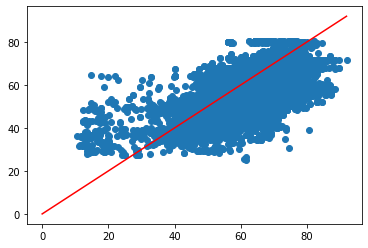

In [8]:
plt.scatter(y_test, lin_reg.predict(pipeline.transform(X_test)))
plt.plot([0, max(y_test)], [0, max(y_test)], color="red")
plt.show()

In [9]:
mean_absolute_percentage_error(y_test, lin_reg.predict(pipeline.transform(X_test)))
# mean_absolute_percentage_error(y_test, X_test["TSO_price_forecast"])

17.43806651412616

In [10]:
X_test["prediction"] = lin_reg.predict(pipeline.transform(X_test))


c:\users\andre\pycharmprojects\forecaststart\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


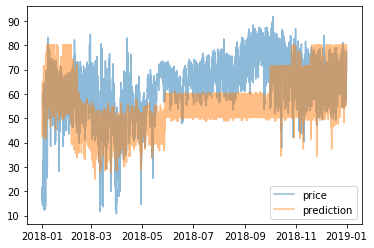

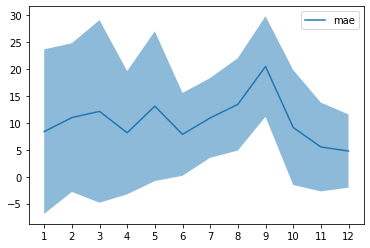

In [17]:
class TimeSeriesPlot:
    def __init__(self, df: pd.DataFrame, target_col:str, prediction_col:str, time_col:str="time"):
        self.df = df.copy(deep=True)
        self.target = target_col
        self.prediction = prediction_col
        self.time = time_col
        self.df['year'] = self.df[self.time].dt.year
        self.df['month'] = self.df[self.time].dt.month
        self.df['day'] = self.df[self.time].dt.day
        self.df['hours'] = self.df[self.time].dt.hour
        self.df["dayofweek"] = self.df[self.time].dt.weekday
        self.df["se"] = self.squared_error()
        self.df["mae"] = self.absolute_error()
        self.df["mape"] = self.absolute_percentage_error()
        
    def squared_error(self):
        return np.power(np.subtract(self.df[self.target], self.df[self.prediction]), 2)
    
    def absolute_error(self):
        return np.abs(np.subtract(self.df[self.target], self.df[self.prediction]))
    
    def absolute_percentage_error(self):
        return np.abs(np.divide(np.subtract(self.df[self.target], self.df[self.prediction]), self.df[self.target])) * 100
    
    def plot_rmse_by_time(self, time:str):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        mean = grouped["se"].mean()
        group_index = [str(index) for index in mean.index]
        plt.plot(group_index, np.sqrt(mean), label="rmse")
        return fig
        
    def plot_multiple(self, *cols: str):
        fig = plt.figure()
        for col in cols:
            plt.plot(self.df[self.time].values, self.df[col].values, alpha=0.5, label=col)
        plt.legend()
        plt.show()
        return fig
        
    def plot_target_by_time(self, time:str, *targets:str):
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        self.df.boxplot(column=[*targets], by=group_by_cols,
                        layout=(targets.__len__(), 1), rot=45, figsize=(50,40), grid=False)
        return plt.gcf()
        
    def plot_target_by_time_band(self, time:str, *targets:str):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        for tar in targets:
            mean = grouped[tar].mean()
            std = grouped[tar].std()
            group_index = [str(index) for index in mean.index]
            plt.plot(group_index, mean, label=tar)
            plt.fill_between(group_index, mean - 2*std, mean + 2*std, alpha=.5)
        plt.legend()
        return fig
        
        
foobar = TimeSeriesPlot(X_test, "price", "prediction")
foobar.plot_multiple("price", "prediction")
#bp = foobar.plot_target_by_time("%m%wd", "price", "prediction")
#bp.savefig("results/foo.png")
band = foobar.plot_target_by_time_band("%m", "mae")
#rmse = foobar.plot_rmse_by_time("%m")
#band.savefig("results/band.png")

#foobar.df.loc[foobar.df["time"].dt.month == 1].std()
#foobar.df["mae"].mean()

19.40313535077567

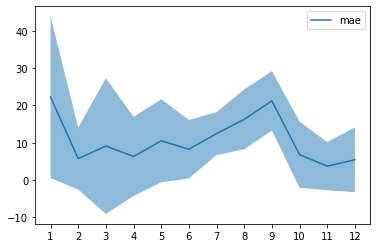

In [18]:
class NaiveModel:
    def __init__(self):
        self.model = {}
        
    def fit(self, df:pd.DataFrame, target:str):
        grouped = df.groupby(by=[df["time"].dt.year, df["time"].dt.month, df["time"].dt.weekday, df["time"].dt.hour])[target].mean()
        for y, m , wd, h in grouped.index:
            self.model[target, y, m, wd, h] = grouped[y, m, wd, h]
    
    def predict(self, df:pd.DataFrame, target:str):
        return df["time"].apply(lambda value: self.model[target, value.year-1, value.month, value.weekday(), value.hour])
    
nm = NaiveModel()
nm.fit(X_train, "price")
nm_x_test = X_test[["time", "price"]].copy(deep=True)
nm_x_test["prediction"] = nm.predict(X_test, "price")
bar = TimeSeriesPlot(nm_x_test, "price", "prediction")
band = bar.plot_target_by_time_band("%m", "mae")
mean_absolute_percentage_error(bar.df["price"], bar.df["prediction"])